In [32]:
import sys
import os
import numpy as np

from PIL import Image
from transformers import TableTransformerForObjectDetection, AutoModelForObjectDetection
from matplotlib import pyplot as plt

from tokenExtraction import TokenReader
from tableExtraction import PretrainTableExtractionPipeline

# Give priority to the modules that are inside tableTransformer 
# and handles the conflict between tableTransformer/detr/datasets and hugging face datasets' library
sys.path.insert(1, os.getcwd() + '/tableTransformer/src')
sys.path.insert(2, os.getcwd() + '/tableTransformer/detr')
# This snipet is necessary for inference to work

from tableTransformer.src.inference import output_result

from dotenv import load_dotenv
load_dotenv() 


True

In [33]:
TABLE_DETECTION_MODEL = AutoModelForObjectDetection.from_pretrained(os.environ['TABLE_DETECTION_MODEL_PATH'], revision="no_timm")
TABLE_STRUCTURE_MODEL = TableTransformerForObjectDetection.from_pretrained(os.environ['TABLE_STRUCTURE_MODEL_PATH'])

In [34]:
table_extraction_pipeline = PretrainTableExtractionPipeline(
    det_device=os.environ['TABLE_DETECTION_DEVICE'], 
    str_device=os.environ['TABLE_STRUCTURE_DEVICE'], 
    det_model=TABLE_DETECTION_MODEL,
    str_model=TABLE_STRUCTURE_MODEL
)

In [36]:
def resize_img(image: Image, factor: float): 
    width, height = image.size
    return image.resize((int(factor*width), (int(factor*height))))

def side_by_side_plot(img1, img2): 
    f, axarr = plt.subplots(1, 2, figsize=(16,9))
    axarr[0].imshow( img1 )
    axarr[1].imshow( img2 )

    axarr[1].axis('off')
    axarr[0].axis('off')
    plt.show()

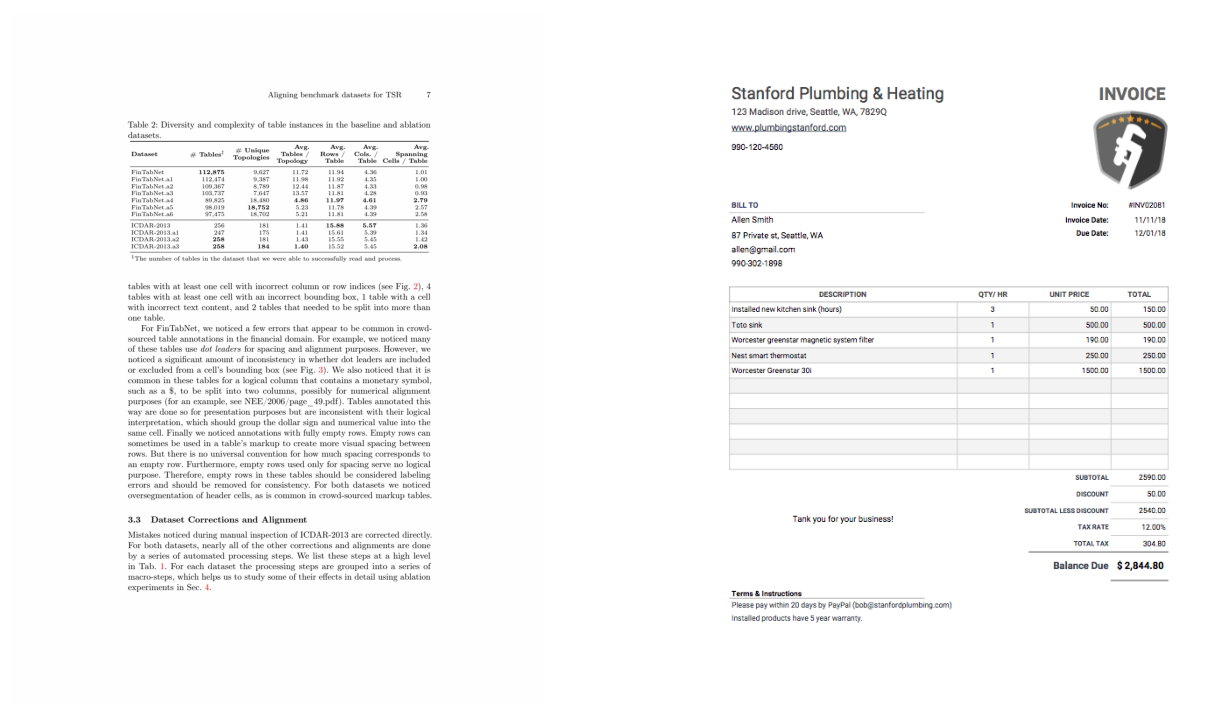

In [37]:
invoice_img_file_name = 'Sample-Invoice-printable.jpg'
paper_img_file_name = '2303_00716.jpg'

paper_image = Image.open(paper_img_file_name).convert('RGB')
invoice_image = Image.open(invoice_img_file_name).convert('RGB')

side_by_side_plot(paper_image, invoice_image)

`tokens` is expected to be a list of dictionaries containing a list of words and their bounding boxes in image coordinates. It is assumed to be sorted in reading order. The format for tokens is:  
```python
[
    {
        'bbox': [0.0, 0.0, 50.0, 50.0],
        'text': 'First'
        'span_num': 1,
        'line_num': <<line_num>> || 0,
        'block_num': <<block_num>> || 0
    },
    {
        'bbox': [52.0, 0.0, 102.0, 50.0],
        'text': 'next'
        'span_num': 2,
        'line_num': <<line_num>> || 0,
        'block_num': <<block_num>> || 0
    }
]
```

Multiple approaches  can be evaluated:
- **OCR the Entire Document**: This approach involves performing OCR on the whole document and subsequently passing the extracted tokens through the processing pipeline. This method is expected to be effective as the extract method reassigns tokens with the output from the previous step in the pipeline. However, this method can be computationally expensive and time-consuming, especially for large documents. On top of this, non-relevant parts of the document may introduce noise that can affect the accuracy of table extraction. 

- **OCR Cropped Tables**: By focusing the OCR process on cropped tables, the extracted tokens can be directly fed into the recognition function. This targeted approach ensures that only relevant data is processed, potentially improving both speed and accuracy.

- **OCR Individual Cells**: As demonstrated in this [tutorial by Niels Rogge](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Inference_with_Table_Transformer_(TATR)_for_parsing_tables.ipynb), OCR can be applied to each cell individually. I will not cover this method as it presumes that tokens are obtained following the table structure extraction. However, the positional information of tokens significantly aids in structure detection, as demonstrated by the `tableTransformer.src.inference.objects_to_structures` function.


I'm using [EasyOCR](www.jaided.ai/easyocr/) to get tokens from images: 
- You can find here the documentation: http://www.jaided.ai/easyocr/documentation/   
- Here is a nice Quickstart Tutorial: https://medium.com/@adityamahajan.work/easyocr-a-comprehensive-guide-5ff1cb850168

Additional ressources: 
- Improve noisy image quality: https://github.com/microsoft/table-transformer/discussions/146
- Generate tokens for image and pdf: https://github.com/microsoft/table-transformer/issues/121



## OCR the whole document

In [38]:
token_reader = TokenReader(
    language=os.environ['READER_LANGUAGE'], 
    device=os.environ['READER_DEVICE']
)
readtext_args = {'low_text': 0.3}

paper_tokens = token_reader.get_tokens(paper_img_file_name, readtext_args)
invoice_tokens = token_reader.get_tokens(invoice_img_file_name, readtext_args)

Using CPU. Note: This module is much faster with a GPU.


This guy had a similar problem (tokens missing or inexact ponctuation), providing a lower `low_text` solved the issue: https://stackoverflow.com/questions/77738509/easyocr-does-not-recognize-this-number-in-an-image

This guy have a similar issue (an `7` not recognized, does not seem to appear in our case), here how he solved it: https://github.com/JaidedAI/EasyOCR/issues/254#issuecomment-1267379900 

### One step table extraction 

In [39]:
args = type('Args', (object,), {
    'visualize': True, 
    'out_dir': 'outputs/one_step_extraction/',
    'verbose': False
} )

out_options = {
    'out_objects': True,
    'out_cells': True,
    'out_html': True,
    'out_csv': True
}

paper_extracted_tables = table_extraction_pipeline.extract(paper_image, tokens=paper_tokens, **out_options)
invoice_extracted_tables = table_extraction_pipeline.extract(invoice_image, tokens=invoice_tokens, **out_options)

In [44]:
for table_idx, extracted_table in enumerate(paper_extracted_tables):
    for key, val in extracted_table.items():
        output_result(key, val, args, extracted_table['image'], paper_img_file_name.replace('.jpg', f'_crop_{table_idx}.jpg')) 

for table_idx, extracted_table in enumerate(invoice_extracted_tables):
    for key, val in extracted_table.items():
        output_result(key, val, args, extracted_table['image'], invoice_img_file_name.replace('.jpg', f'_crop_{table_idx}.jpg'))

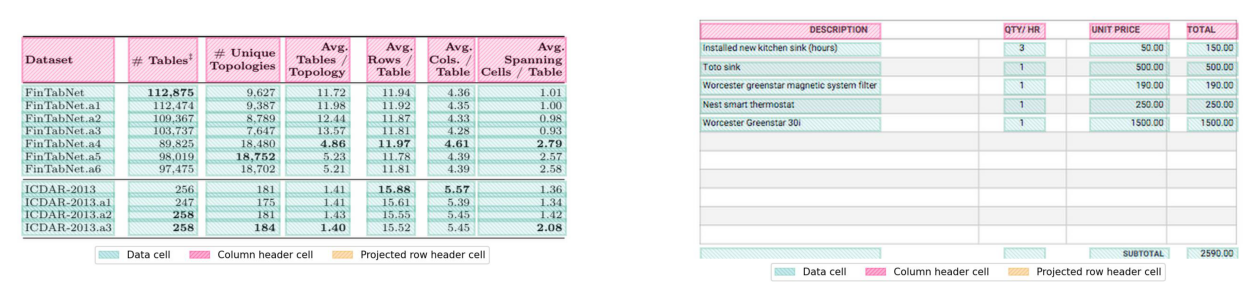

In [41]:
paper_result_one_step_fig_cells = Image.open(args.out_dir + paper_img_file_name.replace('.jpg', '_0_fig_cells.jpg')).convert("RGB")
invoice_result_one_step_fig_cells = Image.open(args.out_dir + invoice_img_file_name.replace('.jpg', '_0_fig_cells.jpg')).convert("RGB")

side_by_side_plot(paper_result_one_step_fig_cells, invoice_result_one_step_fig_cells)

It is okay, but the are some mistakes, for exemple a `,` that become `.,` and another that become `.` and there is a `4` that disapear   
*EDIT*: providing `low_text=0.3` to the reader solves this problem

## OCR the only the cropped tables

### Two Steps table extraction

In [8]:
detection_out_options = {
    'out_objects': True,
    'out_crops': True
}
structure_out_options = {
    'out_objects': True,
    'out_cells': True,
    'out_html': True,
    'out_csv': True
}

args = type('Args', (object,), {
    'visualize':True,
    'out_dir': 'outputs/two_steps_extraction/',
    'verbose': False
})

detected_tables = table_extraction_pipeline.detect(paper_image, **detection_out_options)

for table_idx, crop_table in enumerate(detected_tables['crops']): 
    crop_image = crop_table['image']
    crop_tokens = token_reader.get_tokens(np.array(crop_image), readtext_args)
    
    table_structure = table_extraction_pipeline.recognize(
        crop_image, 
        crop_tokens, 
        **out_options
    )

    for key, val in table_structure.items():
        output_result(key, val, args, crop_image, paper_img_file_name.replace('.jpg', f'_crop_{table_idx}.jpg'))

Having the same kind of problems than the previous method (not the exact same mistakes but inexact ponctuation and missing numbers)   
*EDIT*: providing `low_text=0.3` to the reader solves this problem

The big difference between one step and 2 steps extraction is the column repartition: with one step extraction the colmuns are wider and overlap more than in 2 step extraction.  
Also, you dont have to ocr the whole doc, which means faster result.